# Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import sklearn.metrics as metrics
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jaskaran320 (teamjs). Use `wandb login --relogin` to force relogin


True

# Part 1

## Part a

In [2]:
# Load SVHN dataset
# Convert data to array and change label 10 to 0
# If GPU is available use it, otherwise use CPU

dataset = loadmat('../Data/SVHN Cropped Dataset/train_32x32.mat')
dataset['X'] = np.moveaxis(dataset['X'], -1, 0)
dataset['y'][dataset['y'] == 10] = 0
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
# Split the dataset into train, validation, and test sets

train_size = int(0.7 * len(dataset['X']))
val_size = int(0.2 * len(dataset['X']))
test_size = len(dataset['X']) - train_size - val_size

train_data = dataset['X'][:train_size]
val_data = dataset['X'][train_size:train_size+val_size]
test_data = dataset['X'][train_size+val_size:]

train_labels = dataset['y'][:train_size]
val_labels = dataset['y'][train_size:train_size+val_size]
test_labels = dataset['y'][train_size+val_size:]

## Part b

In [4]:
class ClassificationDataset(Dataset):
    def __init__(self, images, labels, transform=None, target_transform=None, transform_bool=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.transform_bool = transform_bool

    def transformation(self, images, labels):
        transform = transforms.Compose([
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
        ])
        images = transform(images)
        return images, labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        images = self.images[index]
        label = self.labels[index]
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            label = self.target_transform(label)

        if self.transform_bool:
            images, label = self.transformation(images, label)
            
        return images, label

In [5]:
# We define the train, test and validation sets for the neural network using the datset class and dataloader

train_dataset = ClassificationDataset(train_data, train_labels, transform=transforms.ToTensor())
val_dataset = ClassificationDataset(val_data, val_labels, transform=transforms.ToTensor())
test_dataset = ClassificationDataset(test_data, test_labels, transform=transforms.ToTensor())

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Part c

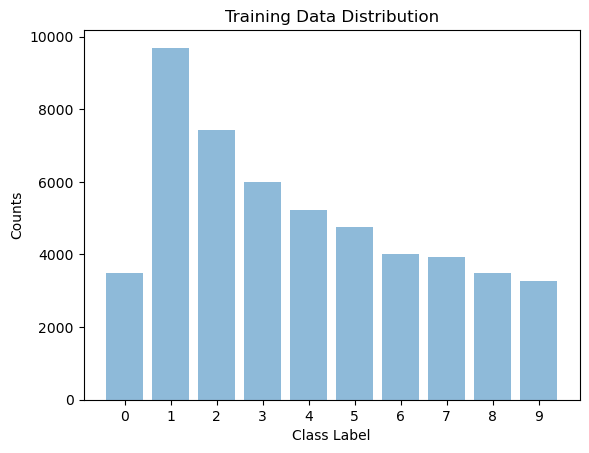

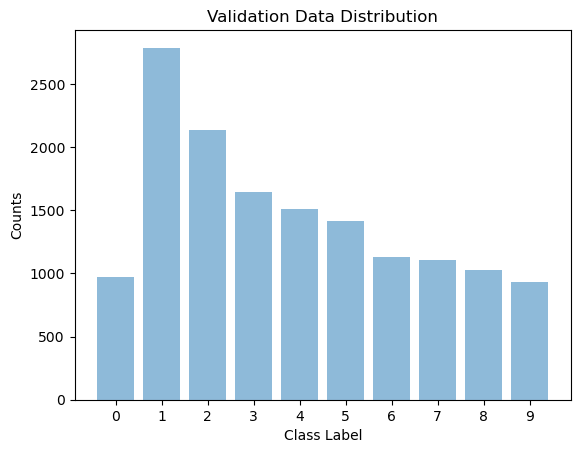

In [7]:
def plot_distribution(data, title):
    unique, counts = np.unique(data, return_counts=True)
    plt.bar(unique, counts, align='center', alpha=0.5)
    plt.xticks(unique)
    plt.ylabel('Counts')
    plt.xlabel('Class Label')
    plt.title(title)
    plt.show()

plot_distribution(train_labels, 'Training Data Distribution')
plot_distribution(val_labels, 'Validation Data Distribution')

# Part 2

## Part a

In [7]:
# This is a convolutional neural network that takes in a 3x32x32 image as input and returns a 10 dimensional vector as output
# The model takes in an input image and passes it through 2 convolutional layers, followed by 2 fully connected layers
# The output of the network has 10 neurons, each representing a class label

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 64*8*8)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [8]:
# We create a CNN model and sets the hyperparameters.
# The model is then trained and tested.

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
wandb.init(project="cv_assignment_1", entity="teamjs", name="Q1.2")
wandb.config = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
}
wandb.watch(model, log="all")

[]

## Part b

In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        val_running_loss = 0.0
        val_running_corrects = 0
        for _, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.float()
            labels = labels.squeeze()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {epoch_loss:.4f} - Training Accuracy: {epoch_acc:.4f}")

        with torch.no_grad():
            for _, (val_inputs, val_labels) in enumerate(val_loader):
                val_inputs = val_inputs.float()
                val_labels = val_labels.squeeze()
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                _, val_preds = torch.max(val_outputs, 1)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_inputs.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels)

            val_epoch_loss = val_running_loss / len(val_loader.dataset)
            val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
            val_losses.append(val_epoch_loss)
            val_acc.append(val_epoch_acc)
            print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_epoch_loss:.4f} - Validation Accuracy: {val_epoch_acc:.4f}")
            
        wandb.log({"Training Loss": epoch_loss, "Validation Loss": val_epoch_loss})
        wandb.log({"Training Accuracy": epoch_acc, "Validation Accuracy": val_epoch_acc})
    return train_losses, val_losses, train_acc, val_acc

In [15]:
train_losses, val_losses, train_acc, val_acc = train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=epochs)

Epoch 1/10 - Training Loss: 1.3556 - Training Accuracy: 0.5511
Epoch 1/10 - Validation Loss: 0.7320 - Validation Accuracy: 0.7812
Epoch 2/10 - Training Loss: 0.6100 - Training Accuracy: 0.8223
Epoch 2/10 - Validation Loss: 0.5535 - Validation Accuracy: 0.8368
Epoch 3/10 - Training Loss: 0.4866 - Training Accuracy: 0.8569
Epoch 3/10 - Validation Loss: 0.4967 - Validation Accuracy: 0.8548
Epoch 4/10 - Training Loss: 0.4247 - Training Accuracy: 0.8744
Epoch 4/10 - Validation Loss: 0.4703 - Validation Accuracy: 0.8616
Epoch 5/10 - Training Loss: 0.3771 - Training Accuracy: 0.8886
Epoch 5/10 - Validation Loss: 0.4555 - Validation Accuracy: 0.8701
Epoch 6/10 - Training Loss: 0.3390 - Training Accuracy: 0.8998
Epoch 6/10 - Validation Loss: 0.4416 - Validation Accuracy: 0.8698
Epoch 7/10 - Training Loss: 0.3070 - Training Accuracy: 0.9085
Epoch 7/10 - Validation Loss: 0.4187 - Validation Accuracy: 0.8821
Epoch 8/10 - Training Loss: 0.2764 - Training Accuracy: 0.9180
Epoch 8/10 - Validation Los

## Part c

Accuracy: 0.8851
F1-Score: 0.8846


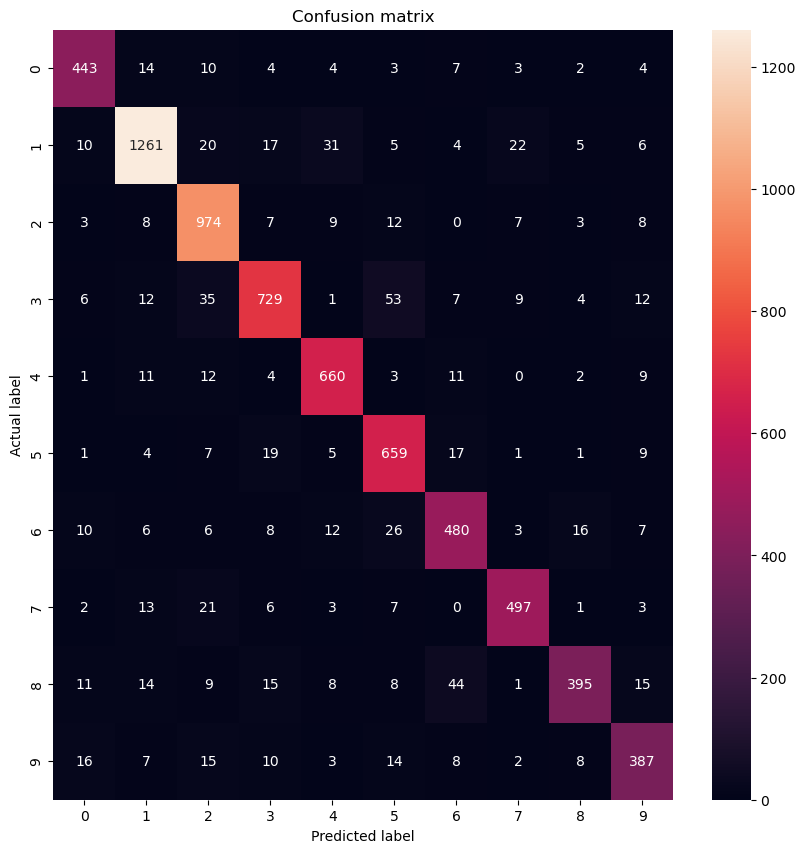

In [16]:
# testing code
predictions = []
true_labels = []
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions += list(predicted.cpu().numpy())
        true_labels += list(labels.cpu().numpy())

accuracy = metrics.accuracy_score(true_labels, predictions)
f1_score = metrics.f1_score(true_labels, predictions, average='weighted')
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Log metrics to wandb
wandb.log({
    "Test Accuracy": accuracy,
    "Test F1-Score": f1_score
})

wandb.log({"Confusion Matrix": wandb.Image(plt)})

# Save model
torch.save(model.state_dict(), 'model_1.pth')
artifact = wandb.Artifact('model_1', type='model')
artifact.add_file('model_1.pth')
wandb.log_artifact(artifact)

In [17]:
wandb.finish()

Test Accuracy,▁
Test F1-Score,▁
Training Accuracy,▁▆▇▇▇▇████
Training Loss,█▃▃▂▂▂▂▁▁▁
Validation Accuracy,▁▅▆▆▇▇████
Validation Loss,█▄▃▂▂▂▁▁▁▁
Test Accuracy,0.88508
Test F1-Score,0.88463
Training Accuracy,0.93253
Training Loss,0.22586
Validation Accuracy,0.88417


In [ ]:
# model = CNN().to(device)
# model.load_state_dict(torch.load('model_1.pth'))

## Part d

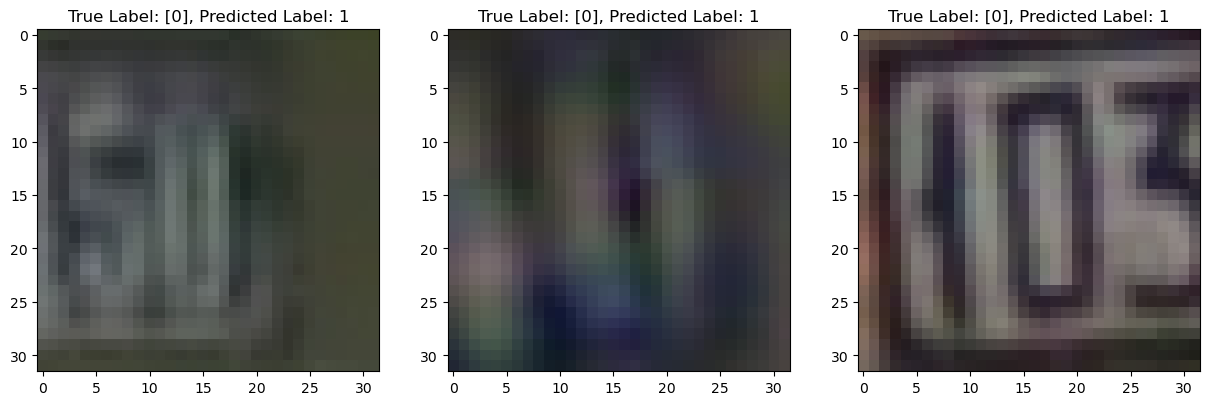

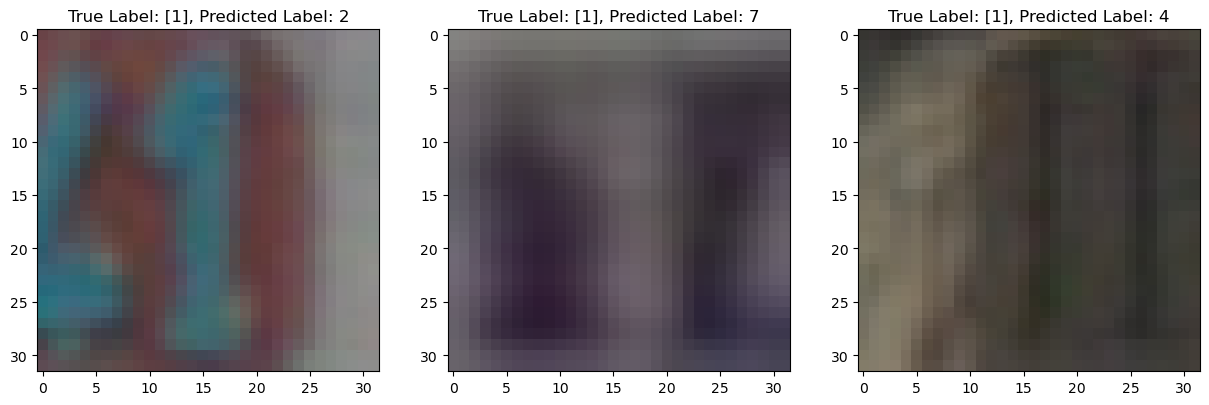

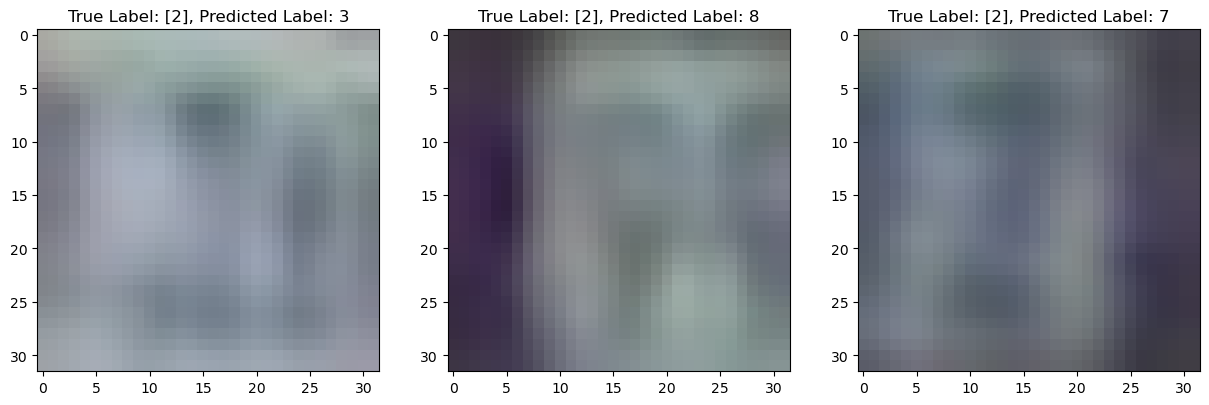

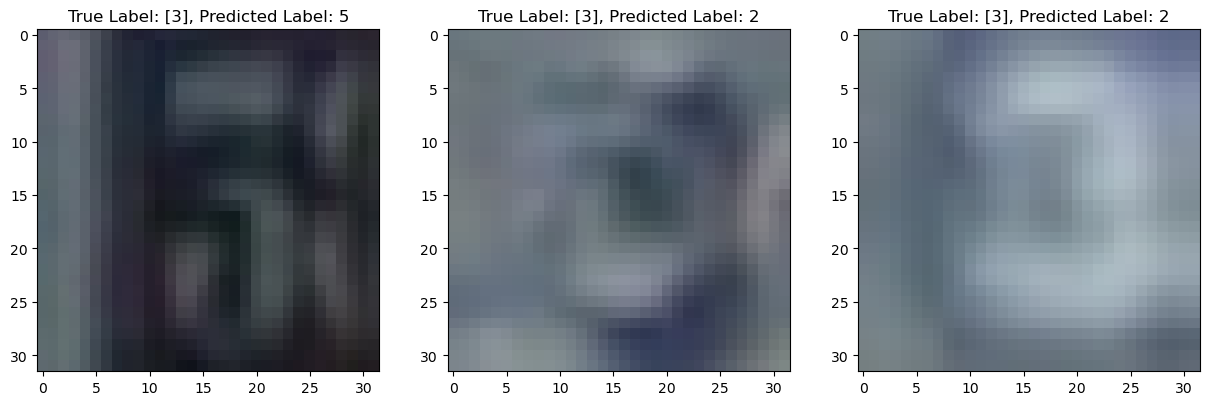

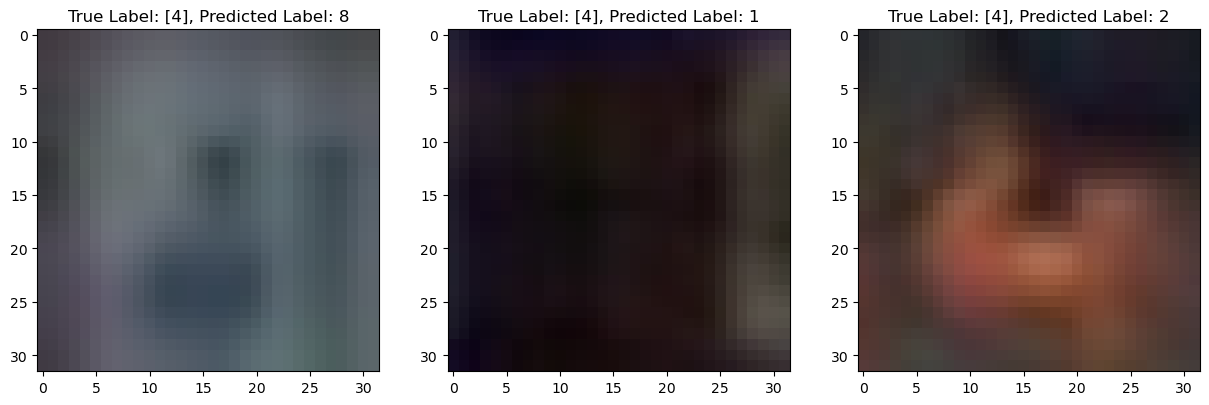

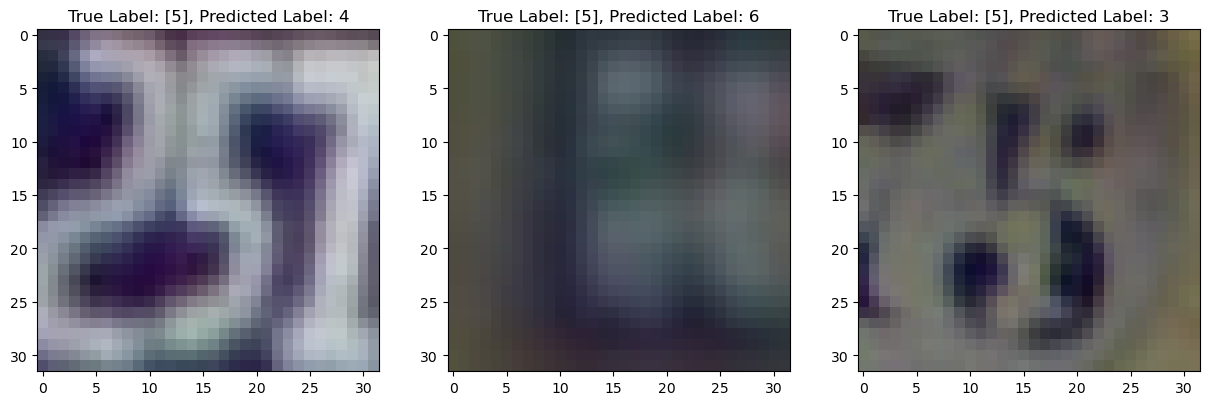

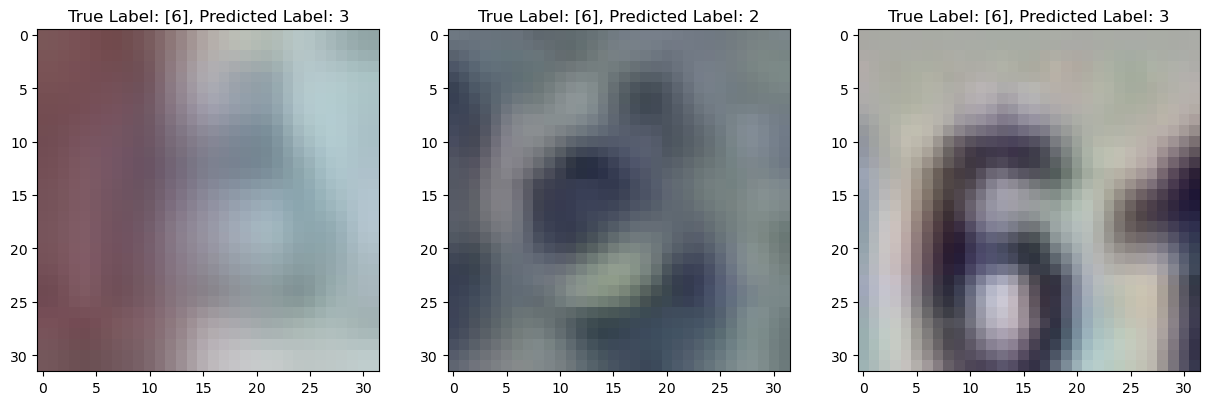

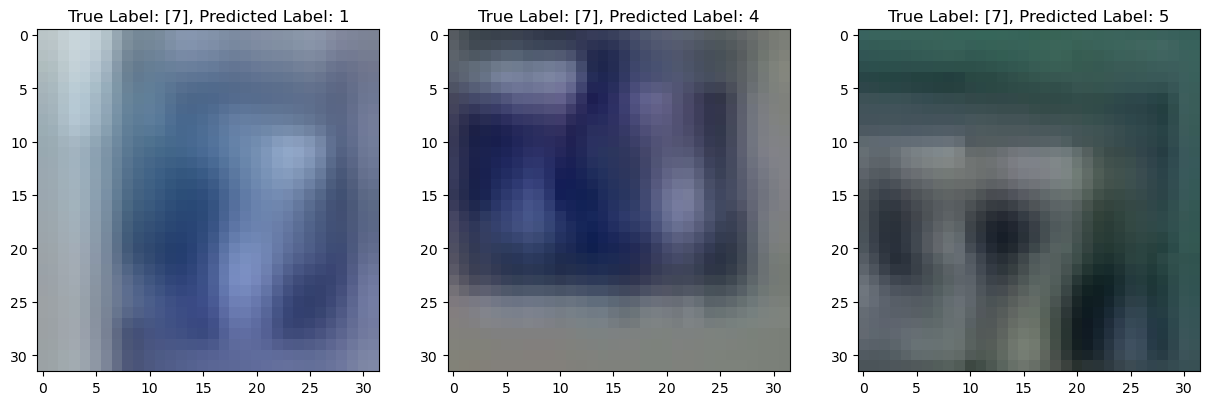

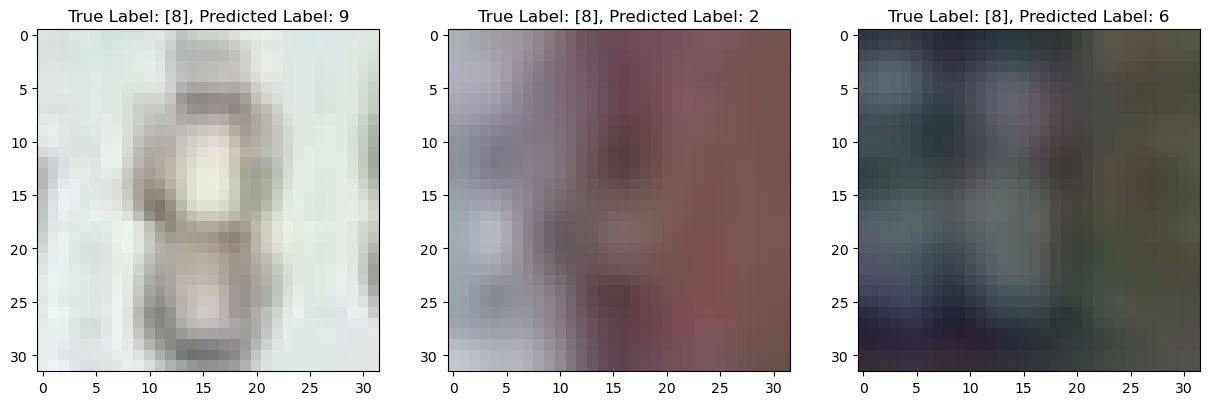

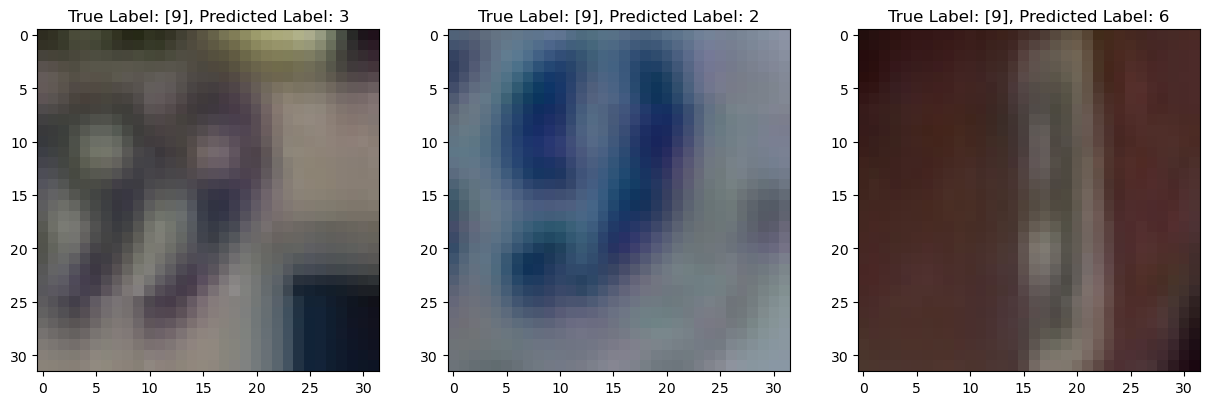

In [24]:
misclassified_indices = []
for i in range(len(true_labels)):
    if true_labels[i] != predictions[i]:
        misclassified_indices.append(i)

for i in range(10):
    class_misclassified_indices = [j for j in misclassified_indices if true_labels[j] == i]
    if len(class_misclassified_indices) == 0:
        continue
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for j, idx in enumerate(class_misclassified_indices[:3]):
        image, label = test_dataset[idx]
        axes[j].imshow(image.permute(1, 2, 0))
        axes[j].set_title(f"True Label: {label}, Predicted Label: {predictions[idx]}")
    plt.show()

# Part 3

## Part a

In [6]:
# import resnet18 model
resnet_model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
resnet_model = resnet_model.to(device)

# define hyperparameters
learning_rate = 1e-3
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=learning_rate)

In [8]:
wandb.init(project="cv_assignment_1", entity="teamjs", name="Q1.3")
wandb.config.update({
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": batch_size,
})
wandb.watch(resnet_model, log="all")

[]

In [7]:
def train_resnet(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        val_running_loss = 0.0
        val_running_corrects = 0
        for _, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.float()
            labels = labels.squeeze()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {epoch_loss:.4f} - Training Accuracy: {epoch_acc:.4f}")

        with torch.no_grad():
            for _, (val_inputs, val_labels) in enumerate(val_loader):
                val_inputs = val_inputs.float()
                val_labels = val_labels.squeeze()
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                _, val_preds = torch.max(val_outputs, 1)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_inputs.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels.data)
            val_epoch_loss = val_running_loss / len(val_loader.dataset)
            val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
            val_losses.append(val_epoch_loss)
            val_acc.append(val_epoch_acc)
            print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_epoch_loss:.4f} - Validation Accuracy: {val_epoch_acc:.4f}")
            
        wandb.log({"Training Loss": epoch_loss, "Validation Loss": val_epoch_loss})
        wandb.log({"Training Accuracy": epoch_acc, "Validation Accuracy": val_epoch_acc})
    return train_losses, val_losses, train_acc, val_acc

In [8]:
train_losses, val_losses, train_acc, val_acc = train_resnet(resnet_model, train_dataloader, val_dataloader, criterion, optimizer, epochs=epochs)

Epoch 1/10 - Training Loss: 0.6015 - Training Accuracy: 0.8129
Epoch 1/10 - Validation Loss: 0.3949 - Validation Accuracy: 0.8786
Epoch 2/10 - Training Loss: 0.3269 - Training Accuracy: 0.9027
Epoch 2/10 - Validation Loss: 0.3366 - Validation Accuracy: 0.9012
Epoch 3/10 - Training Loss: 0.2582 - Training Accuracy: 0.9242
Epoch 3/10 - Validation Loss: 0.3036 - Validation Accuracy: 0.9102
Epoch 4/10 - Training Loss: 0.2152 - Training Accuracy: 0.9376
Epoch 4/10 - Validation Loss: 0.3061 - Validation Accuracy: 0.9139
Epoch 5/10 - Training Loss: 0.1897 - Training Accuracy: 0.9450
Epoch 5/10 - Validation Loss: 0.2774 - Validation Accuracy: 0.9205
Epoch 6/10 - Training Loss: 0.1651 - Training Accuracy: 0.9521
Epoch 6/10 - Validation Loss: 0.2842 - Validation Accuracy: 0.9201
Epoch 7/10 - Training Loss: 0.1405 - Training Accuracy: 0.9594
Epoch 7/10 - Validation Loss: 0.3038 - Validation Accuracy: 0.9190
Epoch 8/10 - Training Loss: 0.1297 - Training Accuracy: 0.9637
Epoch 8/10 - Validation Los

In [8]:
# resnet_model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
# resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
# resnet_model.load_state_dict(torch.load('model_2.pth'))
# resnet_model = resnet_model.to(device)

## Part b

Accuracy: 0.9217
F1-Score: 0.9215


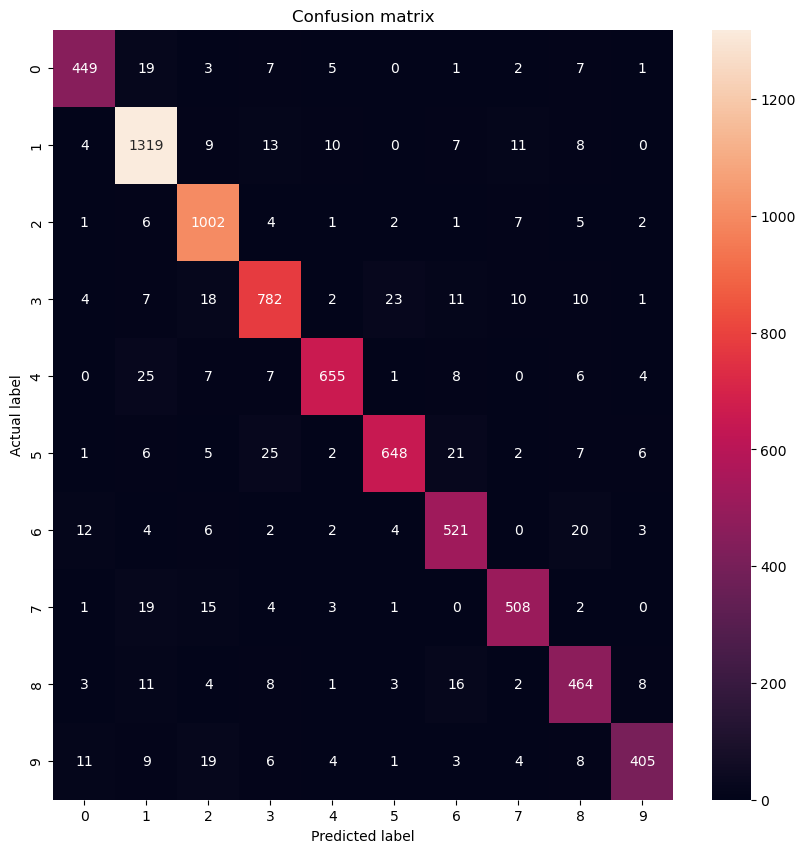

In [9]:
# testing the model
predictions = []
true_labels = []
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions += list(predicted.cpu().numpy())
        true_labels += list(labels.cpu().numpy())

accuracy = metrics.accuracy_score(true_labels, predictions)
f1_score = metrics.f1_score(true_labels, predictions, average='weighted')
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)

# plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# log metrics to wandb
wandb.log({
    "Test Accuracy": accuracy,
    "Test F1-Score": f1_score
})

wandb.log({"Confusion Matrix": wandb.Image(plt)})

# save model
torch.save(resnet_model.state_dict(), 'model_2.pth')
artifact = wandb.Artifact('model_2', type='model')
artifact.add_file('model_2.pth')
wandb.log_artifact(artifact)

In [12]:
wandb.finish()

Test Accuracy,▁
Test F1-Score,▁
Training Accuracy,▁▅▆▆▇▇▇███
Training Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▇▆▇▇█▇▇█
Validation Loss,█▅▁▂▂▂▁▃▄▄
Test Accuracy,0.92057
Test F1-Score,0.9204
Training Accuracy,0.97332
Training Loss,0.09029
Validation Accuracy,0.92294


## Part c

In [9]:
# extract features from the model
train_features = []
train_labels = []
val_features = []
val_labels = []

features_extracted = torch.nn.Sequential(*list(resnet_model.children())[:-1])

with torch.no_grad():
    for data in train_dataloader:
        images, labels = data
        images = images.to(device)
        features = features_extracted(images).cpu().numpy()
        train_features.extend(features)
        train_labels.extend(labels.numpy())
    
    for data in val_dataloader:
        images, labels = data
        images = images.to(device)
        features = features_extracted(images).cpu().numpy()
        val_features.extend(features)
        val_labels.extend(labels.numpy())
        
train_features = np.array(train_features).squeeze()
train_labels = np.array(train_labels).squeeze()
val_features = np.array(val_features).squeeze()
val_labels = np.array(val_labels).squeeze()

c:\Users\Jaskaran\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Jaskaran\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Jaskaran\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Jaskaran\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


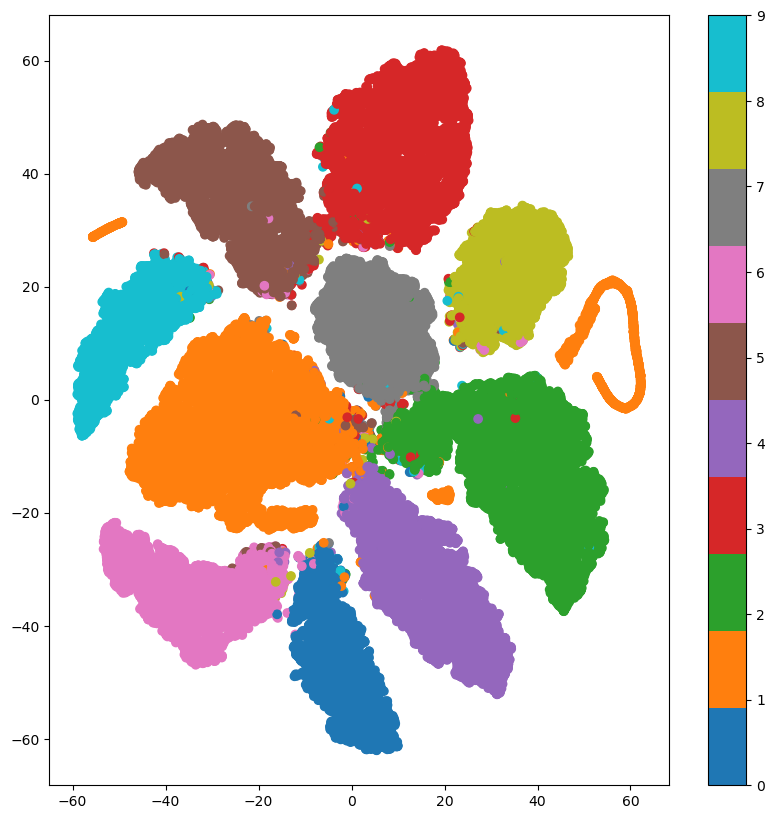

In [16]:
# visualize features
tsne = TSNE(n_components=2, random_state=42)
train_features_2d = tsne.fit_transform(train_features)
val_features_2d = tsne.fit_transform(val_features)

plt.figure(figsize=(10, 10))
plt.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=train_labels, cmap='tab10')
plt.colorbar()
plt.show()

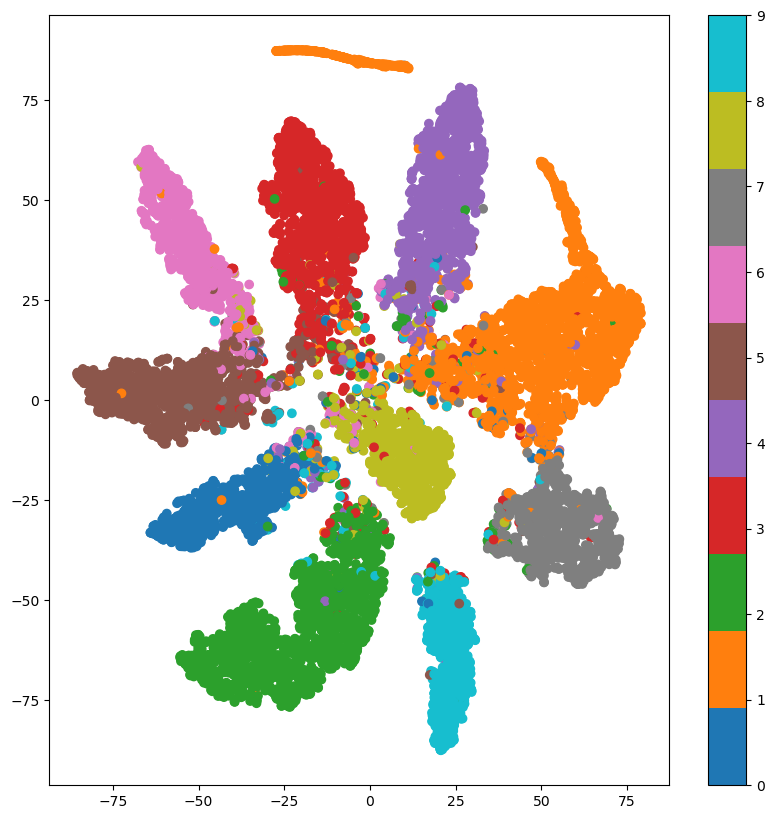

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(val_features_2d[:, 0], val_features_2d[:, 1], c=val_labels, cmap='tab10')
plt.colorbar()
plt.show()

c:\Users\Jaskaran\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Jaskaran\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


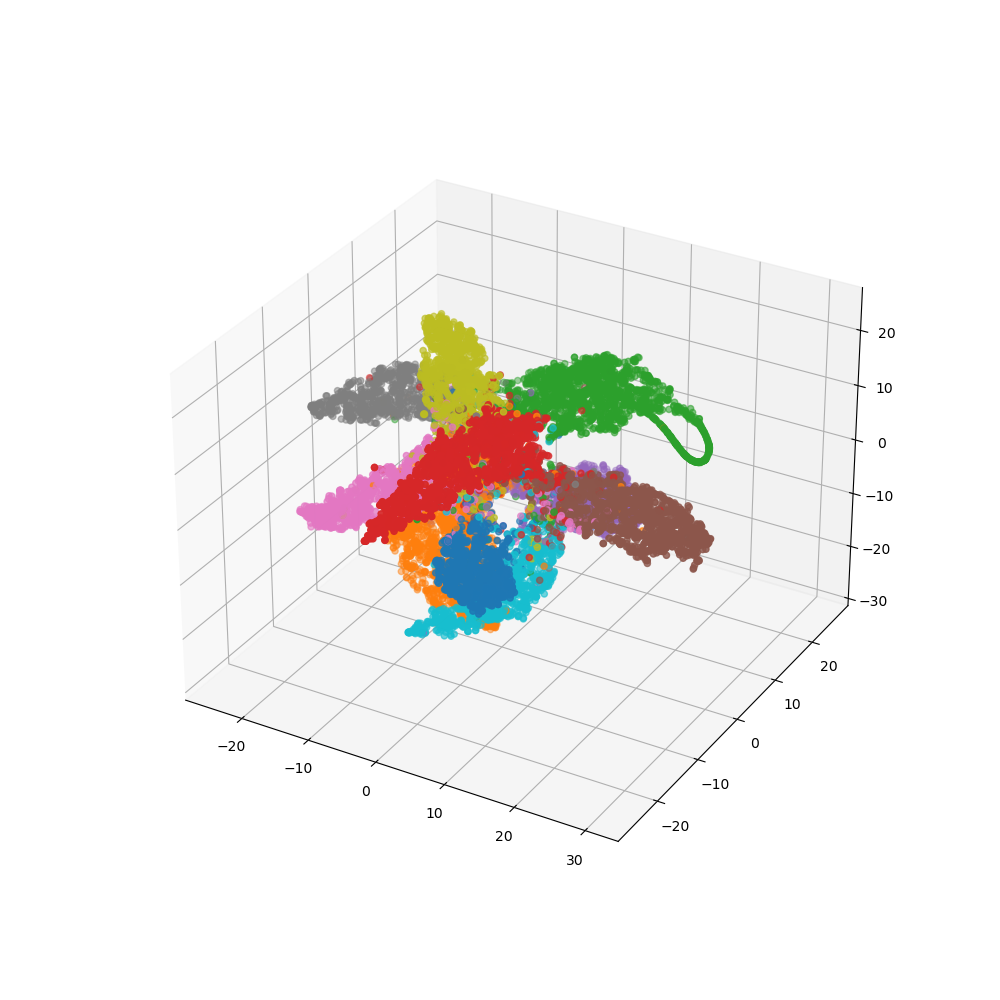

In [10]:
# visualize features in 3D
tsne = TSNE(n_components=3, random_state=42)
val_features_3d = tsne.fit_transform(val_features)

%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(val_features_3d[:, 0], val_features_3d[:, 1], val_features_3d[:, 2], c=val_labels, cmap='tab10')
plt.show()

# Part 4

In [13]:
# creating the augmented dataset
train_dataset = ClassificationDataset(train_data, train_labels, transform=transforms.ToTensor(), transform_bool=True)
val_dataset = ClassificationDataset(val_data, val_labels, transform=transforms.ToTensor())
test_dataset = ClassificationDataset(test_data, test_labels, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
resnet_model_augmented = models.resnet18(weights='ResNet18_Weights.DEFAULT')
resnet_model_augmented.fc = nn.Linear(resnet_model_augmented.fc.in_features, 10)
resnet_model_augmented = resnet_model_augmented.to(device)

# setting the hyperparameters
criterion = nn.CrossEntropyLoss()
epochs = 10
learning_rate = 1e-3
optimizer = torch.optim.Adam(resnet_model_augmented.parameters(), lr=learning_rate)

In [15]:
wandb.init(project="cv_assignment_1", entity="teamjs", name="Q1.4")
wandb.config = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
}
wandb.watch(resnet_model_augmented, log="all")

[]

In [16]:
train_losses, val_losses, train_acc, val_acc = train_resnet(resnet_model_augmented, train_loader, val_loader, criterion, optimizer, epochs=epochs)

Epoch 1/10 - Training Loss: 1.1088 - Training Accuracy: 0.6044
Epoch 1/10 - Validation Loss: 0.7436 - Validation Accuracy: 0.7302
Epoch 2/10 - Training Loss: 0.7088 - Training Accuracy: 0.7519
Epoch 2/10 - Validation Loss: 0.7058 - Validation Accuracy: 0.7452
Epoch 3/10 - Training Loss: 0.6139 - Training Accuracy: 0.7797
Epoch 3/10 - Validation Loss: 0.6191 - Validation Accuracy: 0.7806
Epoch 4/10 - Training Loss: 0.5805 - Training Accuracy: 0.7935
Epoch 4/10 - Validation Loss: 0.6091 - Validation Accuracy: 0.7778
Epoch 5/10 - Training Loss: 0.5505 - Training Accuracy: 0.8044
Epoch 5/10 - Validation Loss: 0.6417 - Validation Accuracy: 0.7767
Epoch 6/10 - Training Loss: 0.5085 - Training Accuracy: 0.8198
Epoch 6/10 - Validation Loss: 0.5814 - Validation Accuracy: 0.7961
Epoch 7/10 - Training Loss: 0.4852 - Training Accuracy: 0.8258
Epoch 7/10 - Validation Loss: 0.5150 - Validation Accuracy: 0.8176
Epoch 8/10 - Training Loss: 0.4708 - Training Accuracy: 0.8310
Epoch 8/10 - Validation Los

Accuracy: 0.8013
F1-Score: 0.8004


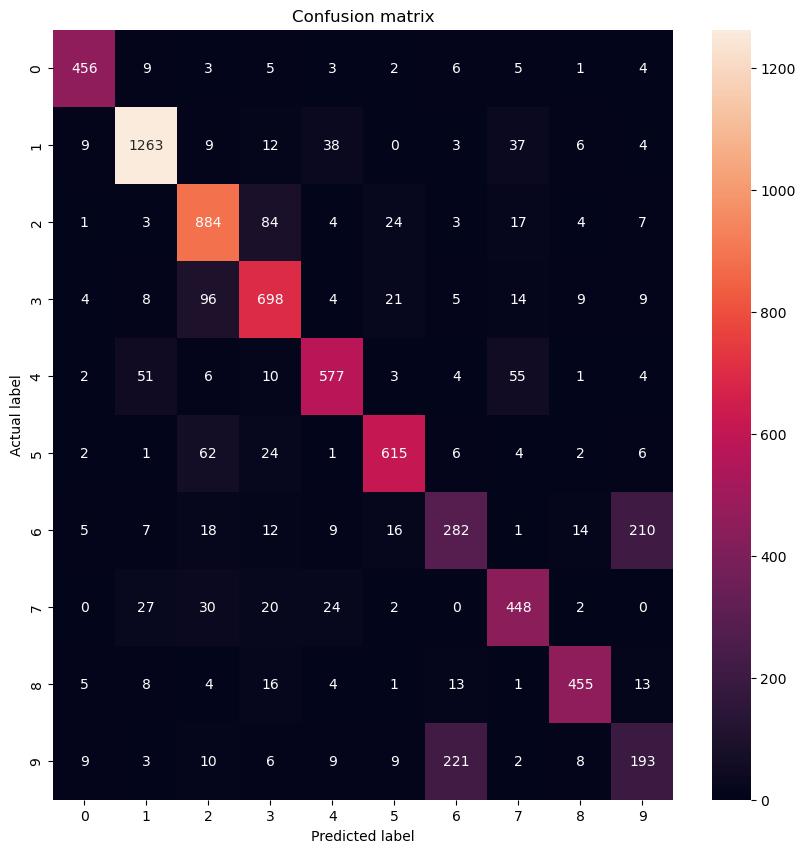

In [17]:
# testing the model
predictions = []
true_labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model_augmented(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions += list(predicted.cpu().numpy())
        true_labels += list(labels.cpu().numpy())

accuracy = metrics.accuracy_score(true_labels, predictions)
f1_score = metrics.f1_score(true_labels, predictions, average='weighted')
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)

# plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# log metrics to wandb
wandb.log({
    "Test Accuracy": accuracy,
    "Test F1-Score": f1_score
})

wandb.log({"Confusion Matrix": wandb.Image(plt)})

# save model
torch.save(resnet_model_augmented.state_dict(), 'model_3.pth')
artifact = wandb.Artifact('model_3', type='model')
artifact.add_file('model_3.pth')
wandb.log_artifact(artifact)

In [18]:
wandb.finish()

Test Accuracy,▁
Test F1-Score,▁
Training Accuracy,▁▅▆▇▇▇▇███
Training Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▂▅▅▅▆█▇▆▆
Validation Loss,█▇▄▄▅▃▁▂▃▂
Test Accuracy,0.80128
Test F1-Score,0.8004
Training Accuracy,0.84298
Training Loss,0.44239
Validation Accuracy,0.79646
